# Imports

In [1]:
!pip install pandas

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score
import shap
from sklearn.feature_extraction.text import TfidfVectorizer

# Create Final Data File
Our model produced "Simplest Predictions.csv", which includes our predictions for the sampled ids. Here, we create a new file for our sampled dataset for analysis.

In [27]:
# Load the CSV files
simplest_predictions = pd.read_csv("Simplest Predictions.csv")
all_data = pd.read_csv("all_data.csv")

In [28]:
# Merge to keep only rows from Simplest Predictions with matching IDs in all_data
merged_data = simplest_predictions[["id", "prediction"]].merge(
    all_data, on="id", how="left"
)

In [29]:
# Filter to keep only rows where the merge found a match (non-null all_data columns)
merged_data = merged_data[merged_data[all_data.columns.difference(["id"])].notnull().any(axis=1)]

In [31]:
# Save the result to a new CSV file
merged_data.to_csv("data.csv", index=False)
print("Merged file saved as 'data.csv'")

Merged file saved as 'data.csv'


In [32]:
# Load data
data = pd.read_csv('data.csv')
data.head()

,id,prediction,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,...,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,939076,0.519476,We've lost any pretense of checks and balances...,train,2017-02-02 16:57:10.196676+00,73,NaN,165776,approved,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
1,5983792,0.551483,"""My only concern is guys sitting on routes aft...",train,2017-09-20 01:03:23.472619+00,102,5983593.0,379586,approved,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5
2,605881,0.512334,(Cont'd)\nWe are only a hierarchy at the teeny...,train,2016-11-16 17:39:36.090537+00,53,605832.0,151790,approved,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4
3,5443752,0.501763,"""Be where you are.""\nWherever you are, note th...",train,2017-06-20 02:31:20.698969+00,13,NaN,345917,approved,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,5
4,818330,0.507709,Don't want to miss that Bed Bath and Beyond fl...,train,2017-01-10 15:15:46.344477+00,13,NaN,160908,approved,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,4


# Exploratory Analysis

In [65]:
# Select classes, as per competition
class_features = ["male","female","homosexual_gay_or_lesbian","christian","jewish","muslim","black","white","psychiatric_or_mental_illness"]

# Apply thresholds
# Toxicity ground truth: >= 0.5 is toxic (1), else non-toxic (0)
data['toxic_label'] = (data['toxicity'] >= 0.5).astype(int)
# Predicted toxicity: >= 0.5 is toxic (1), else non-toxic (0)
data['pred_label'] = (data['prediction'] >= 0.5).astype(int)
# Class features: >= 0.5 is in subgroup (1), else not (0)
binary_data = data[class_features].ge(0.5).astype(int)

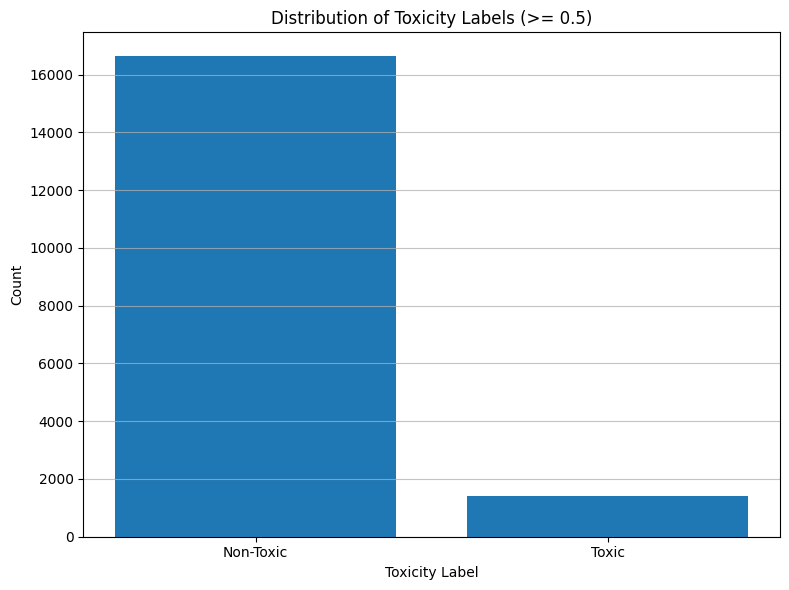


Toxicity label counts:
Non-Toxic (< 0.5): 16629
Toxic (>= 0.5): 1420


In [43]:
# Calculate counts
toxic_counts = data['toxic_label'].value_counts()

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(data['toxic_label'], bins=[-0.5, 0.5, 1.5], rwidth=0.8, align='mid')
plt.xticks([0, 1], ['Non-Toxic', 'Toxic'])
plt.title('Distribution of Toxicity Labels (>= 0.5)')
plt.xlabel('Toxicity Label')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.savefig('toxicity_histogram.png')
plt.show()

# Print counts
print("\nToxicity label counts:")
print(f"Non-Toxic (< 0.5): {toxic_counts.get(0, 0)}")
print(f"Toxic (>= 0.5): {toxic_counts.get(1, 0)}")

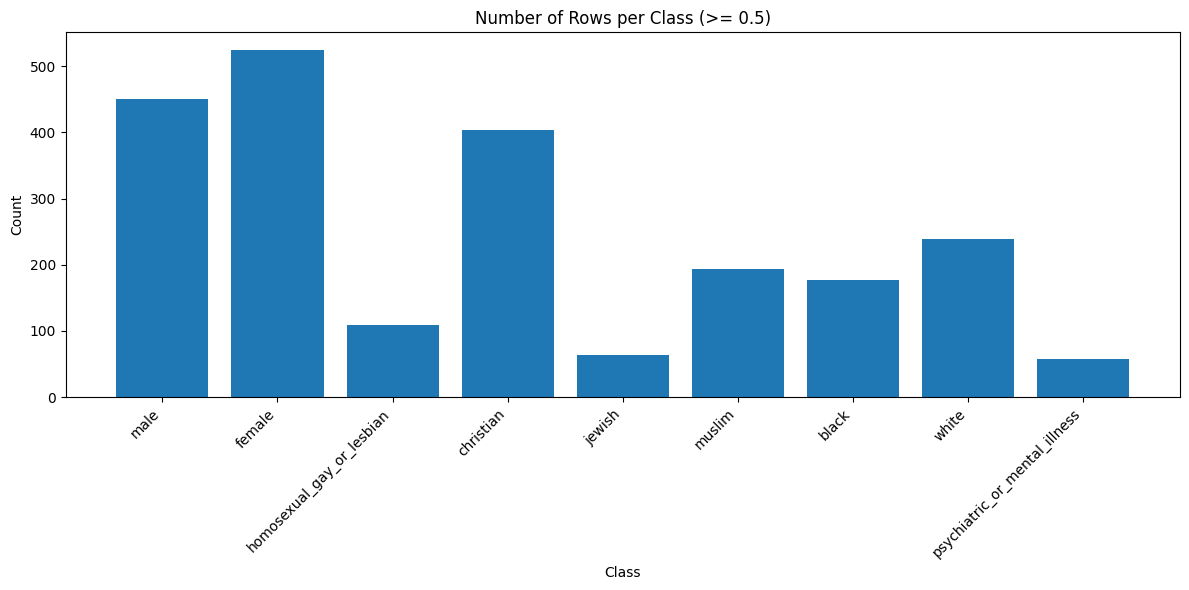


Number of rows where each class is present (>= 0.5):
male: 450
female: 525
homosexual_gay_or_lesbian: 109
christian: 403
jewish: 63
muslim: 193
black: 177
white: 239
psychiatric_or_mental_illness: 57


In [38]:
# Calculate counts of rows where each class is 1
class_counts = binary_data.sum()

# Plot a single bar plot for class counts
plt.figure(figsize=(12, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Number of Rows per Class (>= 0.5)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Print the counts for each class
print("\nNumber of rows where each class is present (>= 0.5):")
for feature, count in class_counts.items():
    print(f"{feature}: {count}")

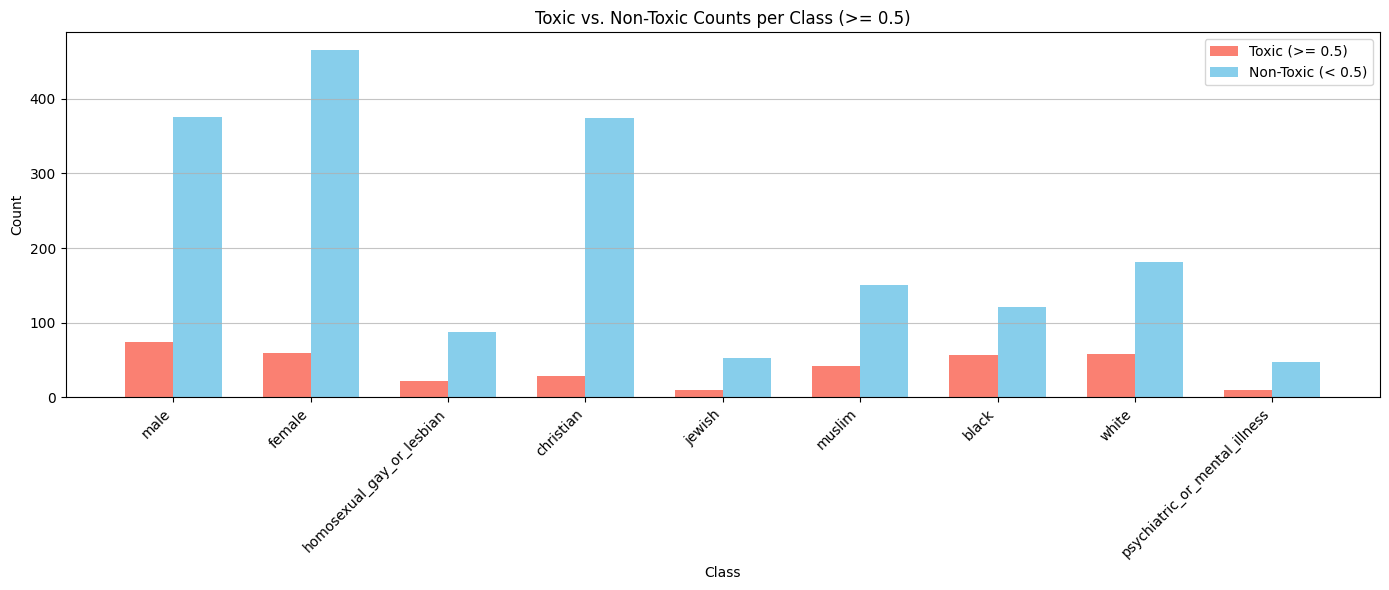


Toxic and Non-Toxic counts per class (>= 0.5):
male:
  Toxic (>= 0.5): 74
  Non-Toxic (< 0.5): 376
female:
  Toxic (>= 0.5): 59
  Non-Toxic (< 0.5): 466
homosexual_gay_or_lesbian:
  Toxic (>= 0.5): 22
  Non-Toxic (< 0.5): 87
christian:
  Toxic (>= 0.5): 28
  Non-Toxic (< 0.5): 375
jewish:
  Toxic (>= 0.5): 10
  Non-Toxic (< 0.5): 53
muslim:
  Toxic (>= 0.5): 42
  Non-Toxic (< 0.5): 151
black:
  Toxic (>= 0.5): 56
  Non-Toxic (< 0.5): 121
white:
  Toxic (>= 0.5): 58
  Non-Toxic (< 0.5): 181
psychiatric_or_mental_illness:
  Toxic (>= 0.5): 10
  Non-Toxic (< 0.5): 47


In [61]:
# Calculate toxic and non-toxic counts for each class
toxic_counts = []
non_toxic_counts = []
for feature in class_features:
    # Rows where the class is 1 (feature >= 0.5)
    class_rows = binary_data[feature] == 1
    # Count toxic (toxic_label == 1) and non-toxic (toxic_label == 0) among those rows
    toxic_count = data[class_rows & (data['toxic_label'] == 1)].shape[0]
    non_toxic_count = data[class_rows & (data['toxic_label'] == 0)].shape[0]
    toxic_counts.append(toxic_count)
    non_toxic_counts.append(non_toxic_count)

# Plot grouped bar plot
plt.figure(figsize=(14, 6))
bar_width = 0.35
x = np.arange(len(class_features))

# Plot bars for toxic and non-toxic
plt.bar(x - bar_width/2, toxic_counts, bar_width, label='Toxic (>= 0.5)', color='salmon')
plt.bar(x + bar_width/2, non_toxic_counts, bar_width, label='Non-Toxic (< 0.5)', color='skyblue')

# Customize plot
plt.xticks(x, class_features, rotation=45, ha='right')
plt.title('Toxic vs. Non-Toxic Counts per Class (>= 0.5)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.savefig('class_toxicity_bar.png')
plt.show()

# Print counts for each class
print("\nToxic and Non-Toxic counts per class (>= 0.5):")
for feature, toxic, non_toxic in zip(class_features, toxic_counts, non_toxic_counts):
    print(f"{feature}:")
    print(f"  Toxic (>= 0.5): {toxic}")
    print(f"  Non-Toxic (< 0.5): {non_toxic}")

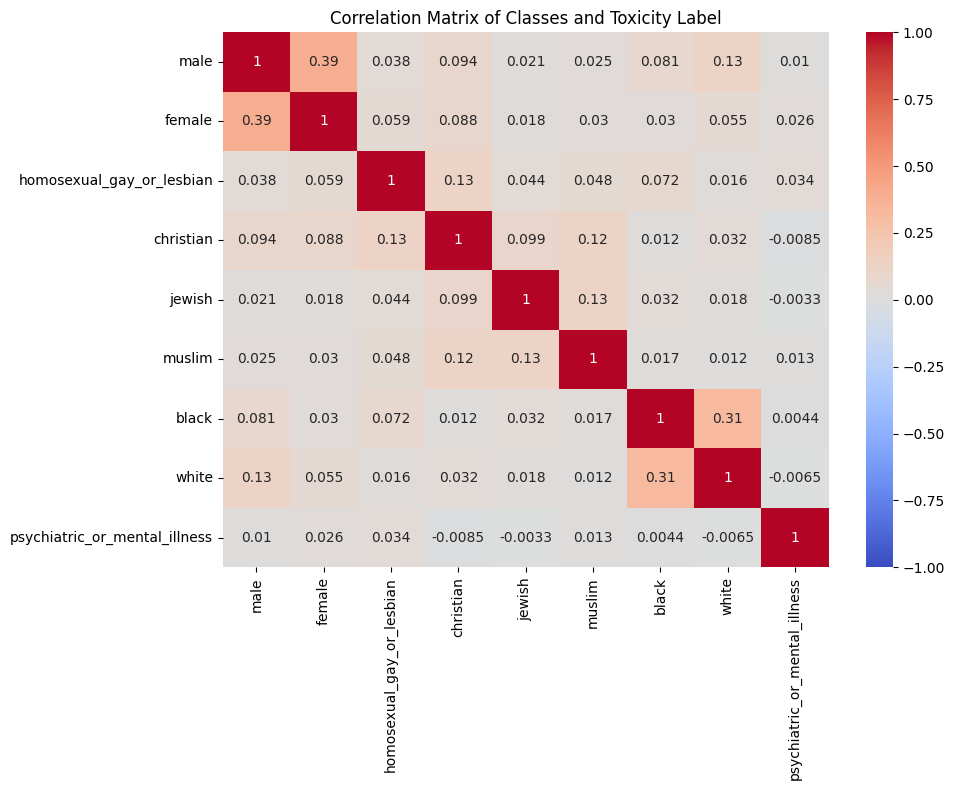


Top 5 unique correlations (absolute values):
female - male: 0.3910
black - white: 0.3131
jewish - muslim: 0.1309
christian - homosexual_gay_or_lesbian: 0.1286
male - white: 0.1276


In [47]:
# Compute correlation matrix
corr_matrix = binary_data.corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Classes and Toxicity Label')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

# Extract top 5 unique correlations
# Convert correlation matrix to a long format, excluding self-correlations
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1]  # Remove self-correlations (1.0)
# Remove duplicates (e.g., A-B and B-A)
unique_pairs = corr_pairs.loc[
    [(a, b) for a, b in corr_pairs.index if a < b]
]
# Sort by absolute value and get top 5
top_5 = unique_pairs.abs().sort_values(ascending=False).head(5)

# Print top 5 correlations
print("\nTop 5 unique correlations (absolute values):")
for (feature1, feature2), corr in top_5.items():
    print(f"{feature1} - {feature2}: {corr_matrix.loc[feature1, feature2]:.4f}")

# Validate Model Performance

In [50]:
# Compute Overall AUC
overall_auc = roc_auc_score(data['toxic_label'], data['prediction'])

In [56]:
# Compute Bias AUCs for each subgroup
bias_aucs = {feature: {'Subgroup': None, 'BPSN': None, 'BNSP': None} for feature in class_features}

for feature in class_features:
    # Subgroup AUC: Rows where subgroup feature is 1
    subgroup_mask = binary_data[feature] == 1
    if subgroup_mask.sum() > 0 and len(data[subgroup_mask]['toxic_label'].unique()) > 1:
        bias_aucs[feature]['Subgroup'] = roc_auc_score(
            data[subgroup_mask]['toxic_label'],
            data[subgroup_mask]['prediction']
        )

    # BPSN AUC: Non-toxic subgroup + toxic non-subgroup
    bpsn_mask = ((data['toxic_label'] == 0) & (binary_data[feature] == 1)) | \
                ((data['toxic_label'] == 1) & (binary_data[feature] == 0))
    if bpsn_mask.sum() > 0 and len(data[bpsn_mask]['toxic_label'].unique()) > 1:
        bias_aucs[feature]['BPSN'] = roc_auc_score(
            data[bpsn_mask]['toxic_label'],
            data[bpsn_mask]['prediction']
        )

    # BNSP AUC: Toxic subgroup + non-toxic non-subgroup
    bnsp_mask = ((data['toxic_label'] == 1) & (binary_data[feature] == 1)) | \
                ((data['toxic_label'] == 0) & (binary_data[feature] == 0))
    if bnsp_mask.sum() > 0 and len(data[bnsp_mask]['toxic_label'].unique()) > 1:
        bias_aucs[feature]['BNSP'] = roc_auc_score(
            data[bnsp_mask]['toxic_label'],
            data[bnsp_mask]['prediction']
        )

In [57]:
# Compute Generalized Mean of Bias AUCs
p = -5  # Power parameter
submetrics = ['Subgroup', 'BPSN', 'BNSP']
generalized_means = {submetric: np.nan for submetric in submetrics}  # Initialize with NaN

for submetric in submetrics:
    # Collect valid AUCs for this submetric
    aucs = [bias_aucs[feature][submetric] for feature in class_features
            if bias_aucs[feature][submetric] is not None]
    print(f"Debug: {submetric} AUCs collected: {aucs}")  # Debug print
    if aucs:  # Only compute if there are valid AUCs
        generalized_means[submetric] = (np.mean([auc ** p for auc in aucs])) ** (1/p)

Debug: Subgroup AUCs collected: [np.float64(0.9021887579068429), np.float64(0.8706808758274532), np.float64(0.7771682340647857), np.float64(0.9170952380952381), np.float64(0.949056603773585), np.float64(0.858561967833491), np.float64(0.8448199527744982), np.float64(0.8093922651933702), np.float64(0.9382978723404256)]
Debug: BPSN AUCs collected: [np.float64(0.908323717239417), np.float64(0.9116592508033414), np.float64(0.797214411392301), np.float64(0.9182097701149426), np.float64(0.8777800080289041), np.float64(0.823727160007305), np.float64(0.7964118659266619), np.float64(0.8294878347571414), np.float64(0.8772672400784669)]
Debug: BNSP AUCs collected: [np.float64(0.9518417389887271), np.float64(0.9322028655109966), np.float64(0.9603516118750068), np.float64(0.9523293167396158), np.float64(0.9789152992277992), np.float64(0.9656432241545726), np.float64(0.9743008800927688), np.float64(0.9599830814772575), np.float64(0.975672415872633)]


In [58]:
# Compute Final Metric
weights = {'overall': 0.25, 'Subgroup': 0.25, 'BPSN': 0.25, 'BNSP': 0.25}
final_metric = (
    weights['overall'] * overall_auc +
    weights['Subgroup'] * generalized_means.get('Subgroup', 0) +
    weights['BPSN'] * generalized_means.get('BPSN', 0) +
    weights['BNSP'] * generalized_means.get('BNSP', 0)
)

In [59]:
# Print Results
print("Model Validation Results")
print("=======================")
print(f"Overall AUC: {overall_auc:.4f}\n")

print("Bias AUCs per Subgroup:")
for feature in class_features:
    print(f"{feature}:")
    print(f"  Subgroup AUC: {bias_aucs[feature]['Subgroup']:.4f}" if bias_aucs[feature]['Subgroup'] is not None else "  Subgroup AUC: N/A")
    print(f"  BPSN AUC: {bias_aucs[feature]['BPSN']:.4f}" if bias_aucs[feature]['BPSN'] is not None else "  BPSN AUC: N/A")
    print(f"  BNSP AUC: {bias_aucs[feature]['BNSP']:.4f}" if bias_aucs[feature]['BNSP'] is not None else "  BNSP AUC: N/A")
    print()

print("Generalized Mean of Bias AUCs (p = -5):")
for submetric in submetrics:
    print(f"  {submetric}: {generalized_means[submetric]:.4f}" if not np.isnan(generalized_means[submetric]) else f"  {submetric}: N/A")

print(f"\nFinal Metric Score: {final_metric:.4f}")

Model Validation Results
Overall AUC: 0.9530

Bias AUCs per Subgroup:
male:
  Subgroup AUC: 0.9022
  BPSN AUC: 0.9083
  BNSP AUC: 0.9518

female:
  Subgroup AUC: 0.8707
  BPSN AUC: 0.9117
  BNSP AUC: 0.9322

homosexual_gay_or_lesbian:
  Subgroup AUC: 0.7772
  BPSN AUC: 0.7972
  BNSP AUC: 0.9604

christian:
  Subgroup AUC: 0.9171
  BPSN AUC: 0.9182
  BNSP AUC: 0.9523

jewish:
  Subgroup AUC: 0.9491
  BPSN AUC: 0.8778
  BNSP AUC: 0.9789

muslim:
  Subgroup AUC: 0.8586
  BPSN AUC: 0.8237
  BNSP AUC: 0.9656

black:
  Subgroup AUC: 0.8448
  BPSN AUC: 0.7964
  BNSP AUC: 0.9743

white:
  Subgroup AUC: 0.8094
  BPSN AUC: 0.8295
  BNSP AUC: 0.9600

psychiatric_or_mental_illness:
  Subgroup AUC: 0.9383
  BPSN AUC: 0.8773
  BNSP AUC: 0.9757

Generalized Mean of Bias AUCs (p = -5):
  Subgroup: 0.8634
  BPSN: 0.8525
  BNSP: 0.9606

Final Metric Score: 0.9074


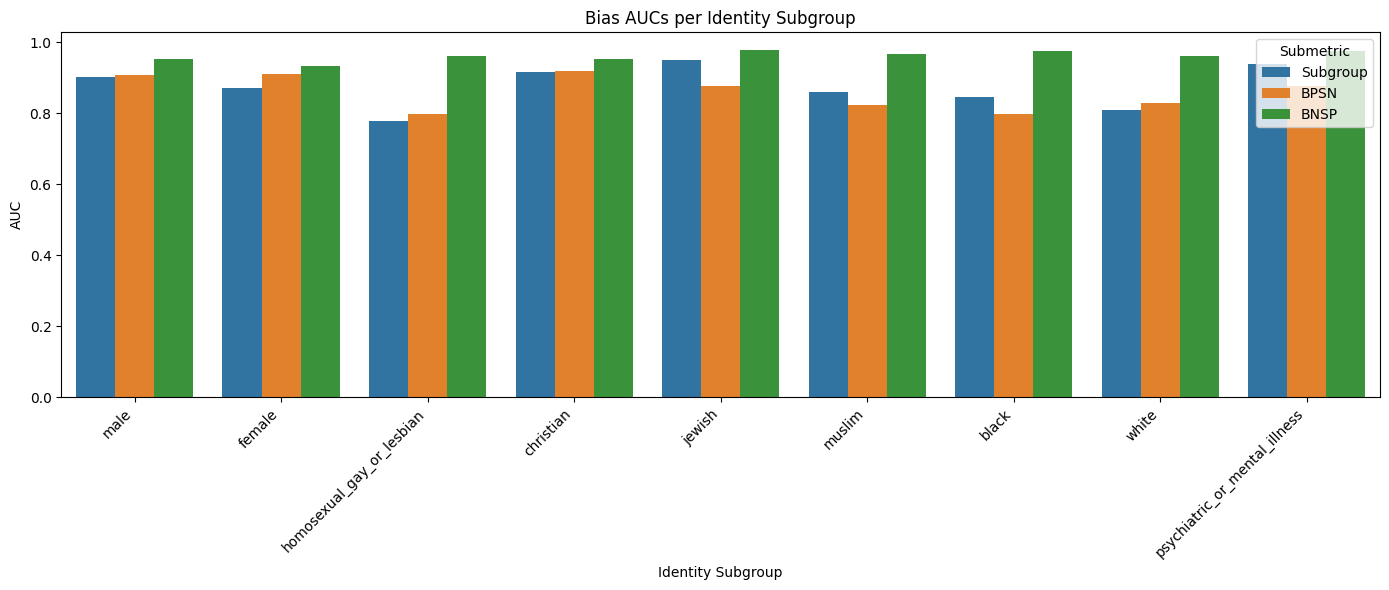

In [62]:
# Create a DataFrame for plotting
bias_auc_df = pd.DataFrame(bias_aucs).T
bias_auc_df = bias_auc_df.reset_index().melt(id_vars='index', value_vars=['Subgroup', 'BPSN', 'BNSP'],
                                             var_name='Submetric', value_name='AUC')
bias_auc_df = bias_auc_df.dropna()  # Remove NaN AUCs for plotting

# Plot bar plot of Bias AUCs
plt.figure(figsize=(14, 6))
sns.barplot(data=bias_auc_df, x='index', y='AUC', hue='Submetric')
plt.xticks(rotation=45, ha='right')
plt.title('Bias AUCs per Identity Subgroup')
plt.xlabel('Identity Subgroup')
plt.ylabel('AUC')
plt.legend(title='Submetric')
plt.tight_layout()
plt.savefig('bias_aucs_bar.png')
plt.show()

# Analyze Accuracy

In [75]:
# Analyze prediction score distribution
print("Prediction Score Distribution:")
print(data['prediction'].describe())
print(f"Proportion of predictions >= 0.5: {(data['prediction'] >= 0.5).mean():.4f}")
print(f"Proportion of predictions >= 0.9: {(data['prediction'] >= 0.9).mean():.4f}\n")

Prediction Score Distribution:
count    18049.000000
mean         0.527350
std          0.039846
min          0.496399
25%          0.504616
50%          0.510390
75%          0.530100
max          0.714927
Name: prediction, dtype: float64
Proportion of predictions >= 0.5: 0.9828
Proportion of predictions >= 0.9: 0.0000



In [66]:
# Compute Overall Confusion Matrix
overall_cm = confusion_matrix(data['toxic_label'], data['pred_label'])
overall_tn, overall_fp, overall_fn, overall_tp = overall_cm.ravel()

In [67]:
# Compute Confusion Matrix per Subgroup
subgroup_cms = {}
subgroup_metrics = {}

for feature in class_features:
    # Restrict to rows where subgroup feature is 1
    subgroup_mask = binary_data[feature] == 1
    subgroup_data = data[subgroup_mask]

    if len(subgroup_data) > 0:
        cm = confusion_matrix(subgroup_data['toxic_label'], subgroup_data['pred_label'])
        # Ensure cm is 2x2; pad with zeros if necessary (e.g., no toxic instances)
        if cm.shape != (2, 2):
            cm_full = np.zeros((2, 2), dtype=int)
            for i in range(min(cm.shape[0], 2)):
                for j in range(min(cm.shape[1], 2)):
                    cm_full[i, j] = cm[i, j]
            cm = cm_full
        tn, fp, fn, tp = cm.ravel()
        subgroup_cms[feature] = cm

        # Compute FPR and FNR
        fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan
        fnr = fn / (tp + fn) if (tp + fn) > 0 else np.nan
        subgroup_metrics[feature] = {'FPR': fpr, 'FNR': fnr, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp}
    else:
        # Handle empty subgroups
        subgroup_cms[feature] = np.zeros((2, 2), dtype=int)
        subgroup_metrics[feature] = {'FPR': np.nan, 'FNR': np.nan, 'TN': 0, 'FP': 0, 'FN': 0, 'TP': 0}

In [68]:
# Print Results
print("Overall Confusion Matrix:")
print(f"True Positives (TP): {overall_tp}")
print(f"False Positives (FP): {overall_fp}")
print(f"False Negatives (FN): {overall_fn}")
print(f"True Negatives (TN): {overall_tn}\n")

print("Confusion Matrices per Subgroup:")
for feature in class_features:
    print(f"{feature}:")
    cm = subgroup_cms[feature]
    tn, fp, fn, tp = subgroup_metrics[feature]['TN'], subgroup_metrics[feature]['FP'], \
                     subgroup_metrics[feature]['FN'], subgroup_metrics[feature]['TP']
    print(f"  True Positives (TP): {tp}")
    print(f"  False Positives (FP): {fp}")
    print(f"  False Negatives (FN): {fn}")
    print(f"  True Negatives (TN): {tn}")
    print(f"  False Positive Rate (FPR): {subgroup_metrics[feature]['FPR']:.4f}" if not np.isnan(subgroup_metrics[feature]['FPR']) else "  False Positive Rate (FPR): N/A")
    print(f"  False Negative Rate (FNR): {subgroup_metrics[feature]['FNR']:.4f}" if not np.isnan(subgroup_metrics[feature]['FNR']) else "  False Negative Rate (FNR): N/A")
    print()

Overall Confusion Matrix:
True Positives (TP): 1420
False Positives (FP): 16319
False Negatives (FN): 0
True Negatives (TN): 310

Confusion Matrices per Subgroup:
male:
  True Positives (TP): 74
  False Positives (FP): 374
  False Negatives (FN): 0
  True Negatives (TN): 2
  False Positive Rate (FPR): 0.9947
  False Negative Rate (FNR): 0.0000

female:
  True Positives (TP): 59
  False Positives (FP): 465
  False Negatives (FN): 0
  True Negatives (TN): 1
  False Positive Rate (FPR): 0.9979
  False Negative Rate (FNR): 0.0000

homosexual_gay_or_lesbian:
  True Positives (TP): 22
  False Positives (FP): 87
  False Negatives (FN): 0
  True Negatives (TN): 0
  False Positive Rate (FPR): 1.0000
  False Negative Rate (FNR): 0.0000

christian:
  True Positives (TP): 28
  False Positives (FP): 375
  False Negatives (FN): 0
  True Negatives (TN): 0
  False Positive Rate (FPR): 1.0000
  False Negative Rate (FNR): 0.0000

jewish:
  True Positives (TP): 10
  False Positives (FP): 53
  False Negat

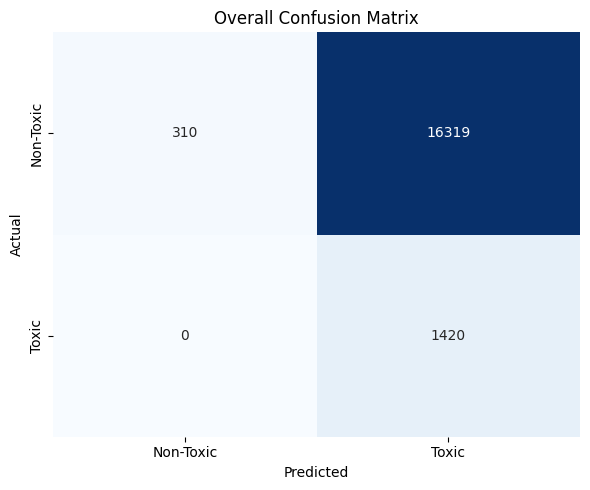

In [69]:
# Visualize Overall Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(overall_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'])
plt.title('Overall Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('overall_confusion_matrix.png')
plt.show()

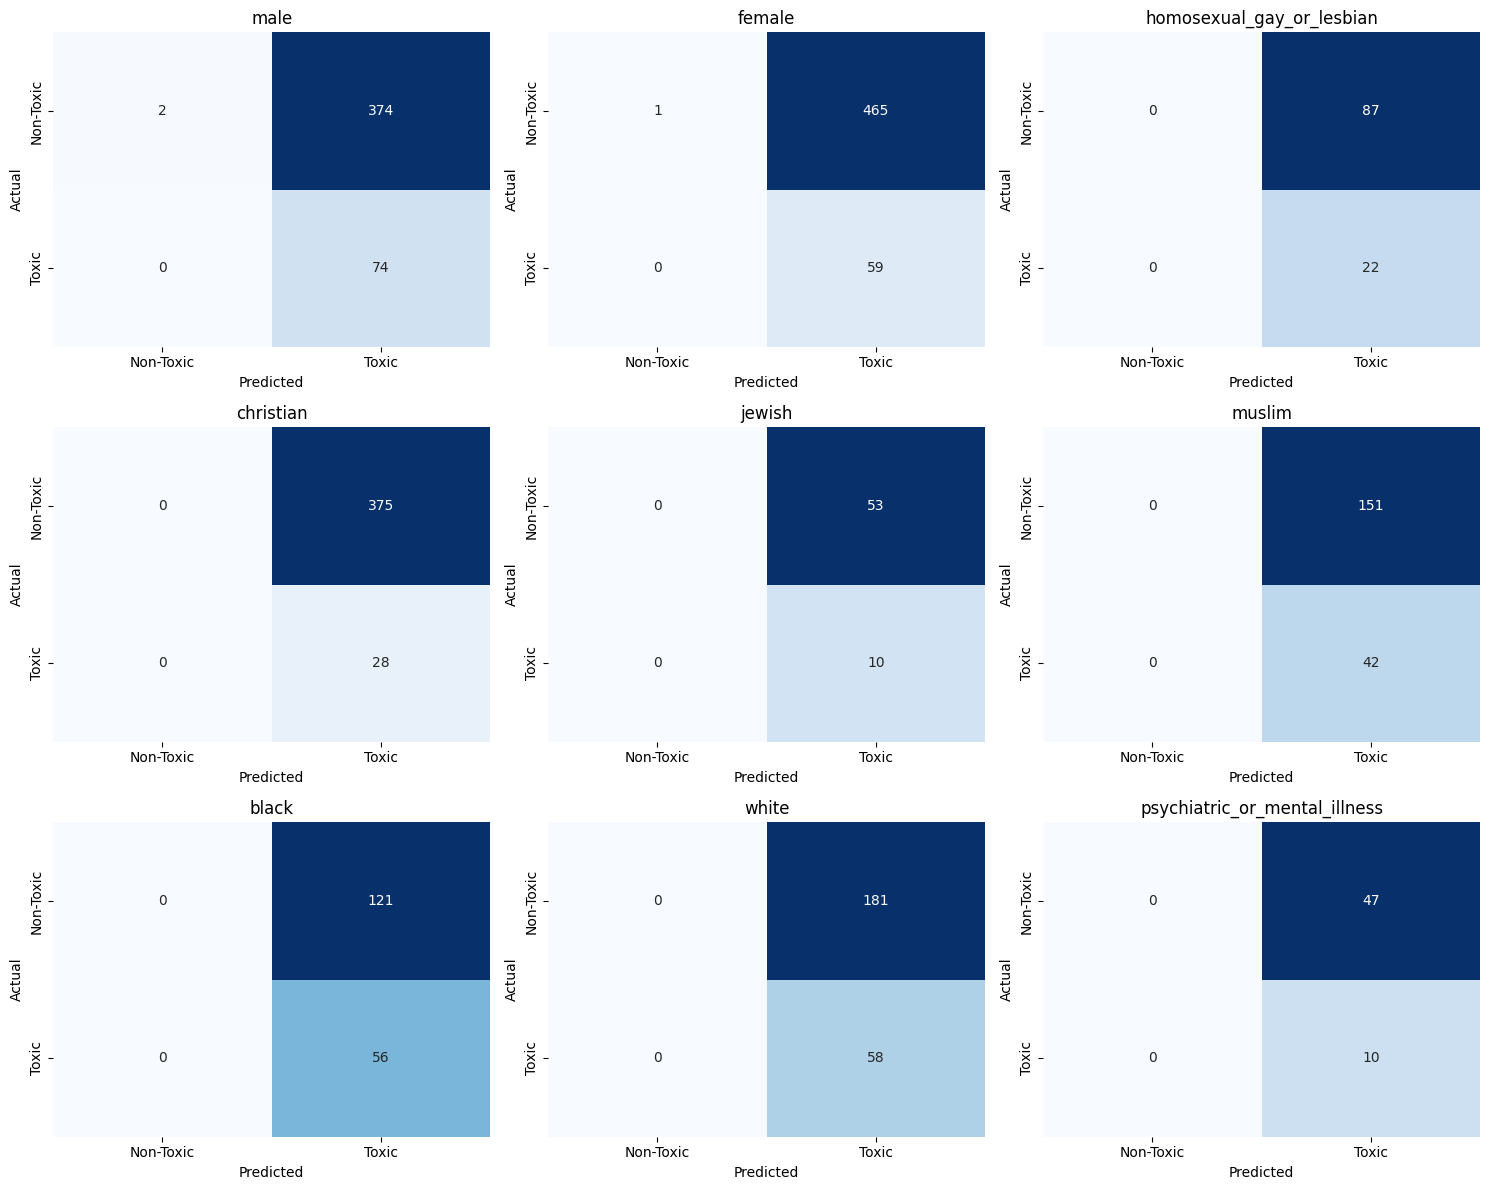

In [70]:
# Visualize Subgroup Confusion Matrices
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(class_features):
    cm = subgroup_cms[feature]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Non-Toxic', 'Toxic'], yticklabels=['Non-Toxic', 'Toxic'], ax=axes[i])
    axes[i].set_title(f'{feature}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('subgroup_confusion_matrices.png')
plt.show()

In [72]:
# Collect FPR and FNR values
fpr_values = [subgroup_metrics[feature]['FPR'] for feature in class_features]
fnr_values = [subgroup_metrics[feature]['FNR'] for feature in class_features]

# Print FPR and FNR values
print("False Positive Rate (FPR) per Subgroup:")
for feature, fpr in zip(class_features, fpr_values):
    print(f"{feature}: {fpr:.4f}" if not np.isnan(fpr) else f"{feature}: N/A")
print("\nFalse Negative Rate (FNR) per Subgroup:")
for feature, fnr in zip(class_features, fnr_values):
    print(f"{feature}: {fnr:.4f}" if not np.isnan(fnr) else f"{feature}: N/A")

False Positive Rate (FPR) per Subgroup:
male: 0.9947
female: 0.9979
homosexual_gay_or_lesbian: 1.0000
christian: 1.0000
jewish: 1.0000
muslim: 1.0000
black: 1.0000
white: 1.0000
psychiatric_or_mental_illness: 1.0000

False Negative Rate (FNR) per Subgroup:
male: 0.0000
female: 0.0000
homosexual_gay_or_lesbian: 0.0000
christian: 0.0000
jewish: 0.0000
muslim: 0.0000
black: 0.0000
white: 0.0000
psychiatric_or_mental_illness: 0.0000


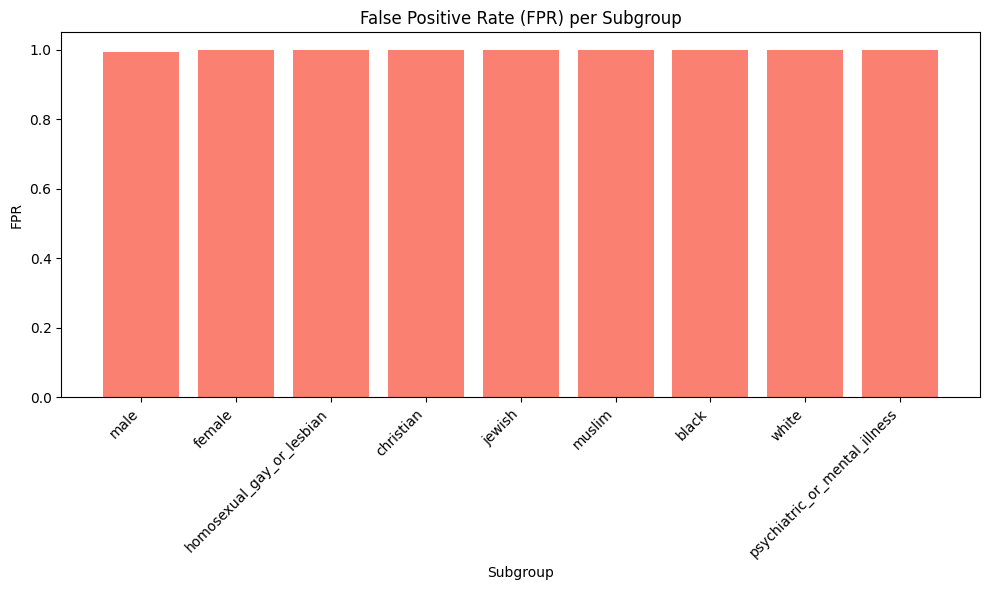

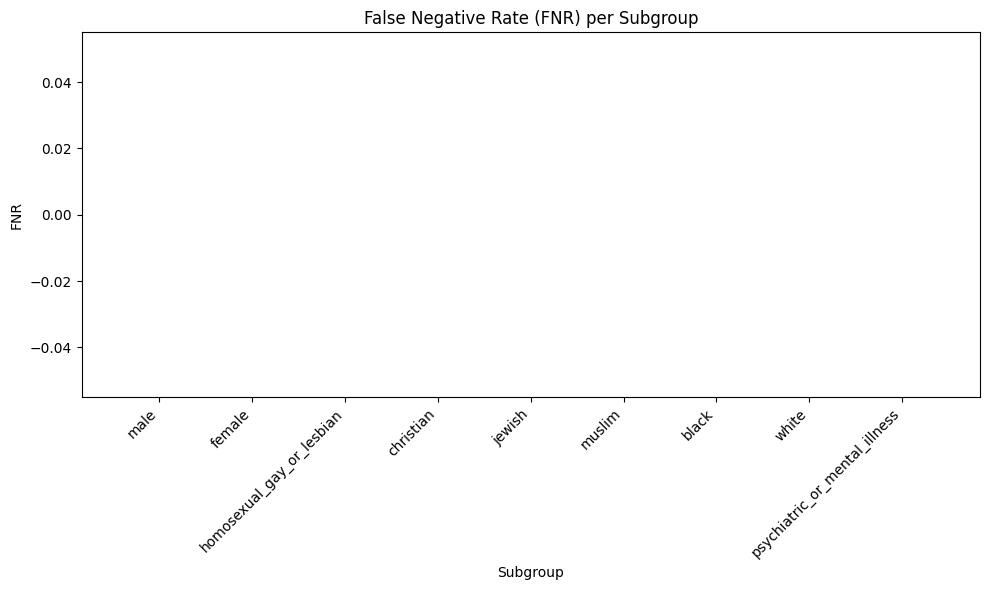

In [74]:
# Visualize FPR and FNR
# FPR Bar Plot
fpr_values = [subgroup_metrics[feature]['FPR'] for feature in class_features]
fnr_values = [subgroup_metrics[feature]['FNR'] for feature in class_features]

plt.figure(figsize=(10, 6))
plt.bar(class_features, fpr_values, color='salmon')
plt.xticks(rotation=45, ha='right')
plt.title('False Positive Rate (FPR) per Subgroup')
plt.xlabel('Subgroup')
plt.ylabel('FPR')
plt.tight_layout()
plt.savefig('fpr_bar.png')
plt.show()

# FNR Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(class_features, fnr_values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title('False Negative Rate (FNR) per Subgroup')
plt.xlabel('Subgroup')
plt.ylabel('FNR')
plt.tight_layout()
plt.savefig('fnr_bar.png')
plt.show()

# Demographic Parity

In [76]:
# Compute Overall Positive Prediction Rate
overall_positive_rate = data['pred_label'].mean()

In [77]:
# Compute Subgroup Positive Prediction Rates and Metrics
subgroup_metrics = {}

for feature in class_features:
    # Restrict to rows where subgroup feature is 1
    subgroup_mask = binary_data[feature] == 1
    subgroup_data = data[subgroup_mask]

    if len(subgroup_data) > 0:
        # Positive prediction rate for subgroup
        subgroup_positive_rate = subgroup_data['pred_label'].mean()
        # Demographic Parity Ratio
        dp_ratio = subgroup_positive_rate / overall_positive_rate if overall_positive_rate > 0 else np.nan
        # Demographic Parity Difference
        dp_diff = abs(subgroup_positive_rate - overall_positive_rate)
        subgroup_metrics[feature] = {
            'Positive_Rate': subgroup_positive_rate,
            'DPRatio': dp_ratio,
            'DPDiff': dp_diff
        }
    else:
        # Handle empty subgroups
        subgroup_metrics[feature] = {
            'Positive_Rate': np.nan,
            'DPRatio': np.nan,
            'DPDiff': np.nan
        }

In [78]:
# Print Results
print("Demographic Parity Metrics")
print("=========================")
print(f"Overall Positive Prediction Rate: {overall_positive_rate:.4f}\n")

print("Per Subgroup Metrics:")
for feature in class_features:
    print(f"{feature}:")
    print(f"  Positive Prediction Rate: {subgroup_metrics[feature]['Positive_Rate']:.4f}" if not np.isnan(subgroup_metrics[feature]['Positive_Rate']) else "  Positive Prediction Rate: N/A")
    print(f"  Demographic Parity Ratio: {subgroup_metrics[feature]['DPRatio']:.4f}" if not np.isnan(subgroup_metrics[feature]['DPRatio']) else "  Demographic Parity Ratio: N/A")
    print(f"  Demographic Parity Difference: {subgroup_metrics[feature]['DPDiff']:.4f}" if not np.isnan(subgroup_metrics[feature]['DPDiff']) else "  Demographic Parity Difference: N/A")
    print()

Demographic Parity Metrics
Overall Positive Prediction Rate: 0.9828

Per Subgroup Metrics:
male:
  Positive Prediction Rate: 0.9956
  Demographic Parity Ratio: 1.0130
  Demographic Parity Difference: 0.0127

female:
  Positive Prediction Rate: 0.9981
  Demographic Parity Ratio: 1.0155
  Demographic Parity Difference: 0.0153

homosexual_gay_or_lesbian:
  Positive Prediction Rate: 1.0000
  Demographic Parity Ratio: 1.0175
  Demographic Parity Difference: 0.0172

christian:
  Positive Prediction Rate: 1.0000
  Demographic Parity Ratio: 1.0175
  Demographic Parity Difference: 0.0172

jewish:
  Positive Prediction Rate: 1.0000
  Demographic Parity Ratio: 1.0175
  Demographic Parity Difference: 0.0172

muslim:
  Positive Prediction Rate: 1.0000
  Demographic Parity Ratio: 1.0175
  Demographic Parity Difference: 0.0172

black:
  Positive Prediction Rate: 1.0000
  Demographic Parity Ratio: 1.0175
  Demographic Parity Difference: 0.0172

white:
  Positive Prediction Rate: 1.0000
  Demographic P

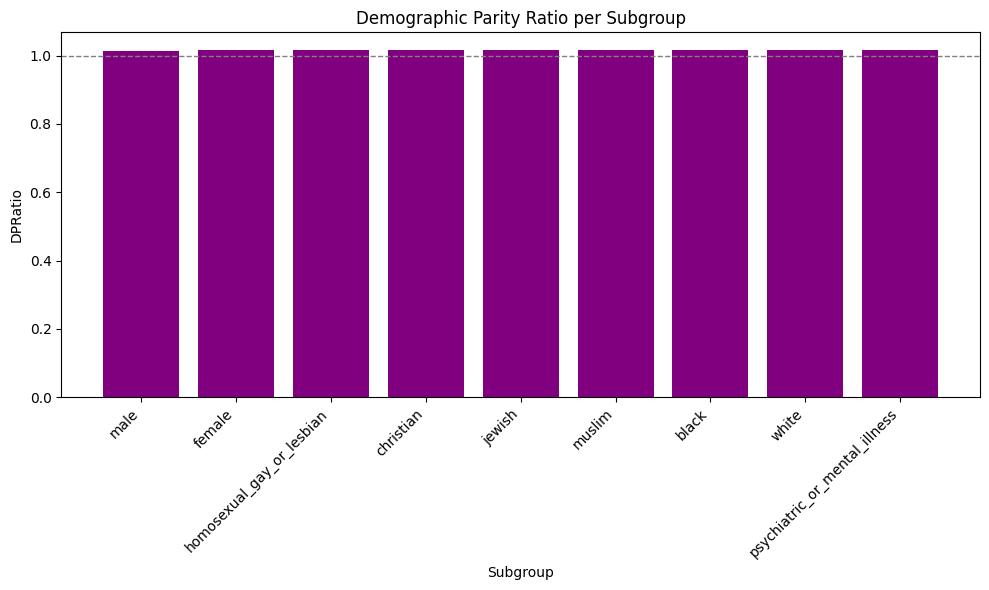

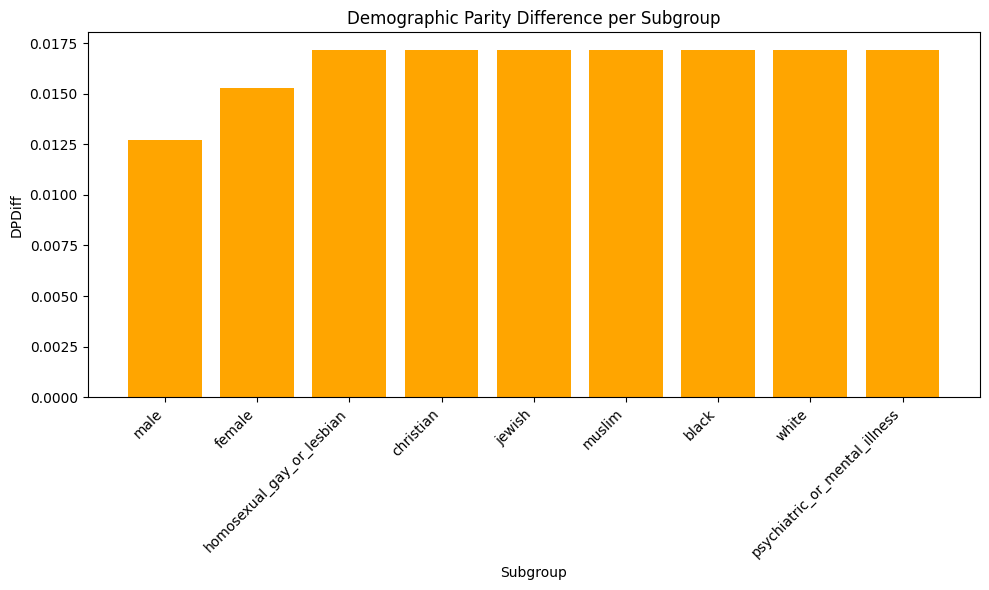

In [79]:
# Visualize DPRatio and DPDiff
# Collect values for plotting
dp_ratio_values = [subgroup_metrics[feature]['DPRatio'] for feature in class_features]
dp_diff_values = [subgroup_metrics[feature]['DPDiff'] for feature in class_features]

# DPRatio Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(class_features, dp_ratio_values, color='purple')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.title('Demographic Parity Ratio per Subgroup')
plt.xlabel('Subgroup')
plt.ylabel('DPRatio')
plt.tight_layout()
plt.savefig('dp_ratio_bar.png')
plt.show()

# DPDiff Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(class_features, dp_diff_values, color='orange')
plt.xticks(rotation=45, ha='right')
plt.title('Demographic Parity Difference per Subgroup')
plt.xlabel('Subgroup')
plt.ylabel('DPDiff')
plt.tight_layout()
plt.savefig('dp_diff_bar.png')
plt.show()

# Precision Disparity

In [80]:
# Compute Overall Precision
overall_tp = ((data['toxic_label'] == 1) & (data['pred_label'] == 1)).sum()
overall_fp = ((data['toxic_label'] == 0) & (data['pred_label'] == 1)).sum()
overall_precision = overall_tp / (overall_tp + overall_fp) if (overall_tp + overall_fp) > 0 else np.nan

In [84]:
# Compute Subgroup Precision and Disparity
subgroup_metrics = {}

for feature in class_features:
    # Restrict to rows where subgroup feature is 1
    subgroup_mask = binary_data[feature] == 1
    subgroup_data = data[subgroup_mask]

    if len(subgroup_data) > 0:
        # Calculate TP and FP for subgroup
        tp = ((subgroup_data['toxic_label'] == 1) & (subgroup_data['pred_label'] == 1)).sum()
        fp = ((subgroup_data['toxic_label'] == 0) & (subgroup_data['pred_label'] == 1)).sum()
        precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
        # Compute disparity metrics
        disparity_ratio = precision / overall_precision if (not np.isnan(precision) and not np.isnan(overall_precision) and overall_precision > 0) else np.nan
        disparity_diff = precision - overall_precision if (not np.isnan(precision) and not np.isnan(overall_precision)) else np.nan
        subgroup_metrics[feature] = {
            'Precision': precision,
            'DisparityRatio': disparity_ratio,
            'DisparityDiff': disparity_diff,
            'TP': tp,
            'FP': fp
        }
    else:
        # Handle empty subgroups
        subgroup_metrics[feature] = {
            'Precision': np.nan,
            'DisparityRatio': np.nan,
            'DisparityDiff': np.nan,
            'TP': 0,
            'FP': 0
        }

In [85]:
# Print Results
print("Precision Disparity Metrics (AIF360-like)")
print("=======================================")
print(f"Overall Precision: {overall_precision:.4f}\n" if not np.isnan(overall_precision) else "Overall Precision: N/A\n")

print("Precision and Disparity per Subgroup:")
for feature in class_features:
    print(f"{feature}:")
    print(f"  Precision: {subgroup_metrics[feature]['Precision']:.4f}" if not np.isnan(subgroup_metrics[feature]['Precision']) else "  Precision: N/A")
    print(f"  Precision Disparity Ratio: {subgroup_metrics[feature]['DisparityRatio']:.4f}" if not np.isnan(subgroup_metrics[feature]['DisparityRatio']) else "  Precision Disparity Ratio: N/A")
    print(f"  Precision Disparity Difference: {subgroup_metrics[feature]['DisparityDiff']:.4f}" if not np.isnan(subgroup_metrics[feature]['DisparityDiff']) else "  Precision Disparity Difference: N/A")
    print(f"  True Positives (TP): {subgroup_metrics[feature]['TP']}")
    print(f"  False Positives (FP): {subgroup_metrics[feature]['FP']}")
    print()

Precision Disparity Metrics (AIF360-like)
Overall Precision: 0.0800

Precision and Disparity per Subgroup:
male:
  Precision: 0.1652
  Precision Disparity Ratio: 2.0635
  Precision Disparity Difference: 0.0851
  True Positives (TP): 74
  False Positives (FP): 374

female:
  Precision: 0.1126
  Precision Disparity Ratio: 1.4066
  Precision Disparity Difference: 0.0325
  True Positives (TP): 59
  False Positives (FP): 465

homosexual_gay_or_lesbian:
  Precision: 0.2018
  Precision Disparity Ratio: 2.5214
  Precision Disparity Difference: 0.1218
  True Positives (TP): 22
  False Positives (FP): 87

christian:
  Precision: 0.0695
  Precision Disparity Ratio: 0.8679
  Precision Disparity Difference: -0.0106
  True Positives (TP): 28
  False Positives (FP): 375

jewish:
  Precision: 0.1587
  Precision Disparity Ratio: 1.9829
  Precision Disparity Difference: 0.0787
  True Positives (TP): 10
  False Positives (FP): 53

muslim:
  Precision: 0.2176
  Precision Disparity Ratio: 2.7185
  Precisio

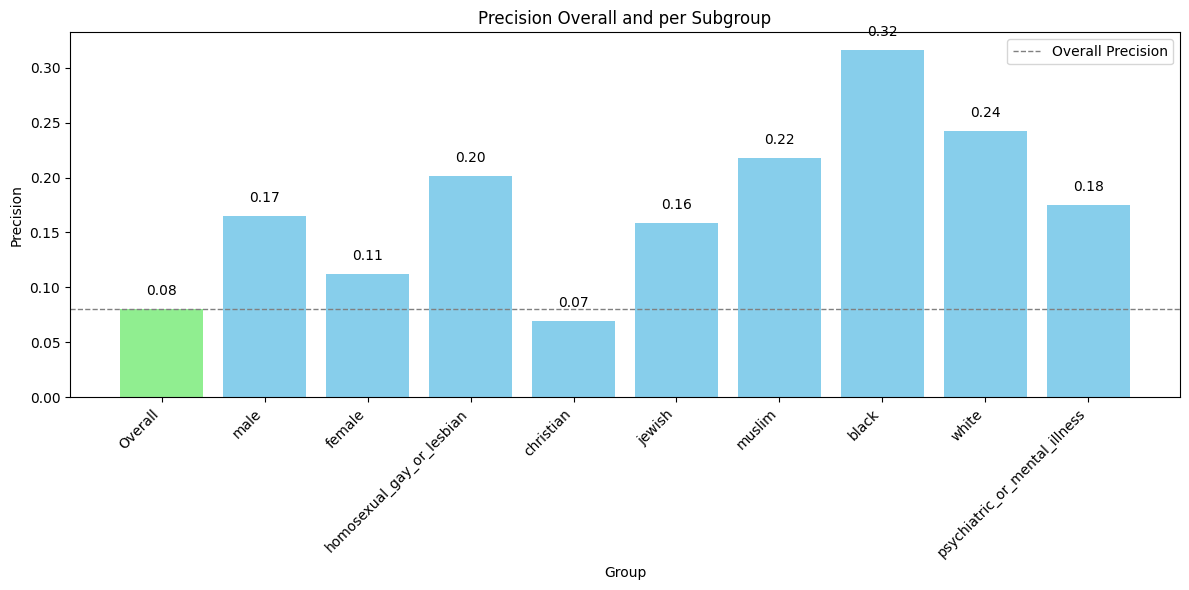

In [88]:
# Visualize Precision
# Collect precision values
precision_values = [subgroup_metrics[feature]['Precision'] for feature in class_features]
plot_labels = ['Overall'] + class_features
plot_values = [overall_precision] + precision_values

# Bar Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(plot_labels, plot_values, color=['lightgreen'] + ['skyblue'] * len(class_features))
plt.axhline(y=overall_precision, color='gray', linestyle='--', linewidth=1, label='Overall Precision')
plt.xticks(rotation=45, ha='right')
plt.title('Precision Overall and per Subgroup')
plt.xlabel('Group')
plt.ylabel('Precision')
plt.legend()
plt.tight_layout()

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    if not np.isnan(yval):
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

plt.savefig('precision_bar.png')
plt.show()

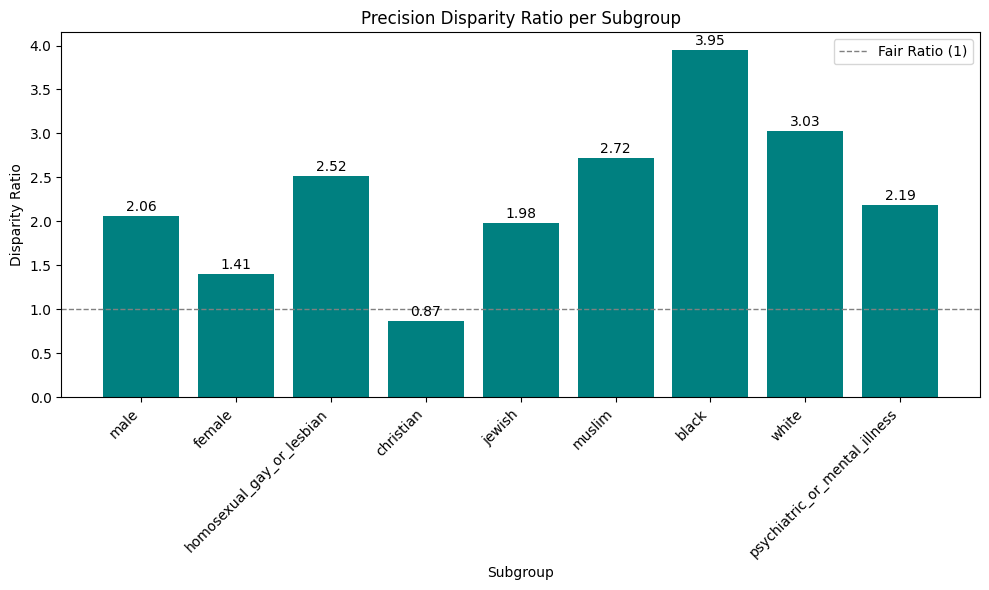

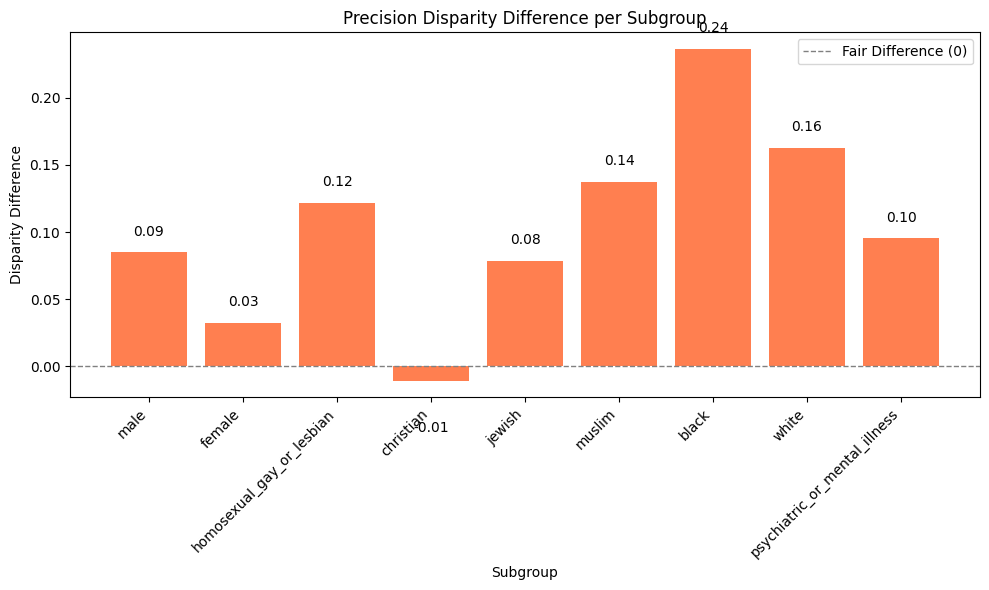

In [86]:
# Visualize Disparity Metrics
# Collect values for plotting
disparity_ratio_values = [subgroup_metrics[feature]['DisparityRatio'] for feature in class_features]
disparity_diff_values = [subgroup_metrics[feature]['DisparityDiff'] for feature in class_features]

# Precision Disparity Ratio Bar Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_features, disparity_ratio_values, color='teal')
plt.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='Fair Ratio (1)')
plt.xticks(rotation=45, ha='right')
plt.title('Precision Disparity Ratio per Subgroup')
plt.xlabel('Subgroup')
plt.ylabel('Disparity Ratio')
plt.legend()
plt.tight_layout()
# Add value labels
for bar in bars:
    yval = bar.get_height()
    if not np.isnan(yval):
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom')
plt.savefig('precision_disparity_ratio_bar.png')
plt.show()

# Precision Disparity Difference Bar Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_features, disparity_diff_values, color='coral')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Fair Difference (0)')
plt.xticks(rotation=45, ha='right')
plt.title('Precision Disparity Difference per Subgroup')
plt.xlabel('Subgroup')
plt.ylabel('Disparity Difference')
plt.legend()
plt.tight_layout()
# Add value labels
for bar in bars:
    yval = bar.get_height()
    if not np.isnan(yval):
        plt.text(bar.get_x() + bar.get_width()/2, yval + (0.01 if yval >= 0 else -0.03), f'{yval:.2f}', ha='center', va='bottom' if yval >= 0 else 'top')
plt.savefig('precision_disparity_diff_bar.png')
plt.show()

# Stability Analysis

In [104]:
# Thresholds to test
thresholds = [0.5, 0.525, 0.55, 0.575, 0.6, 0.625, 0.65]

# Store results
results = {thr: {feature: {'Precision': [], 'Recall': [], 'DP_Ratio': []} for feature in ['Overall'] + class_features} for thr in thresholds}

# Compute metrics for each threshold
for thr in thresholds:
    data['pred_label'] = (data['prediction'] >= thr).astype(int)
    overall_positive_rate = data['pred_label'].mean()
    cm = confusion_matrix(data['toxic_label'], data['pred_label'])
    tn, fp, fn, tp = cm.ravel()
    results[thr]['Overall']['Precision'] = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    results[thr]['Overall']['Recall'] = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    results[thr]['Overall']['DP_Ratio'] = 1.0

    for feature in class_features:
        mask = binary_data[feature] == 1
        subgroup_data = data[mask]
        if len(subgroup_data) > 0:
            positive_rate = subgroup_data['pred_label'].mean()
            cm = confusion_matrix(subgroup_data['toxic_label'], subgroup_data['pred_label'])
            tn, fp, fn, tp = cm.ravel()
            results[thr][feature]['Precision'] = tp / (tp + fp) if (tp + fp) > 0 else np.nan
            results[thr][feature]['Recall'] = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            results[thr][feature]['DP_Ratio'] = positive_rate / overall_positive_rate if overall_positive_rate > 0 else np.nan

In [105]:
# Print results
print("Stability Analysis Across Thresholds:")
for thr in thresholds:
    print(f"\nThreshold = {thr}:")
    for feature in ['Overall'] + class_features:
        print(f"  {feature}:")
        for metric, value in results[thr][feature].items():
            print(f"    {metric}: {value:.4f}" if not np.isnan(value) else f"    {metric}: N/A")

Stability Analysis Across Thresholds:

Threshold = 0.5:
  Overall:
    Precision: 0.0800
    Recall: 1.0000
    DP_Ratio: 1.0000
  male:
    Precision: 0.1652
    Recall: 1.0000
    DP_Ratio: 1.0130
  female:
    Precision: 0.1126
    Recall: 1.0000
    DP_Ratio: 1.0155
  homosexual_gay_or_lesbian:
    Precision: 0.2018
    Recall: 1.0000
    DP_Ratio: 1.0175
  christian:
    Precision: 0.0695
    Recall: 1.0000
    DP_Ratio: 1.0175
  jewish:
    Precision: 0.1587
    Recall: 1.0000
    DP_Ratio: 1.0175
  muslim:
    Precision: 0.2176
    Recall: 1.0000
    DP_Ratio: 1.0175
  black:
    Precision: 0.3164
    Recall: 1.0000
    DP_Ratio: 1.0175
  white:
    Precision: 0.2427
    Recall: 1.0000
    DP_Ratio: 1.0175
  psychiatric_or_mental_illness:
    Precision: 0.1754
    Recall: 1.0000
    DP_Ratio: 1.0175

Threshold = 0.525:
  Overall:
    Precision: 0.2646
    Recall: 0.9556
    DP_Ratio: 1.0000
  male:
    Precision: 0.2840
    Recall: 0.9595
    DP_Ratio: 1.9554
  female:
    Preci

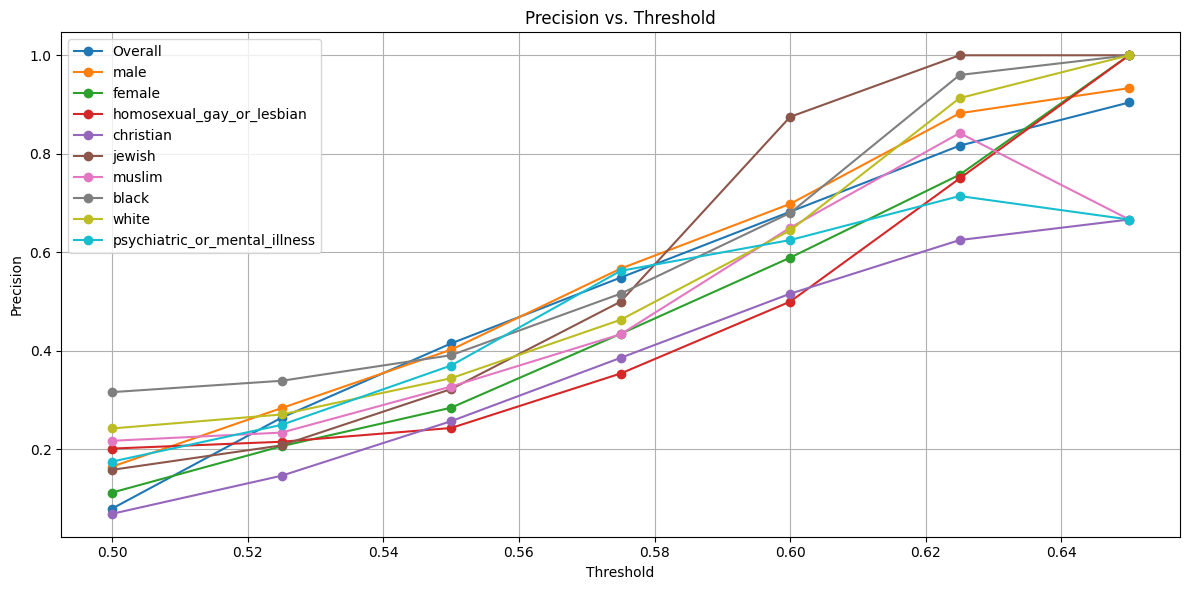

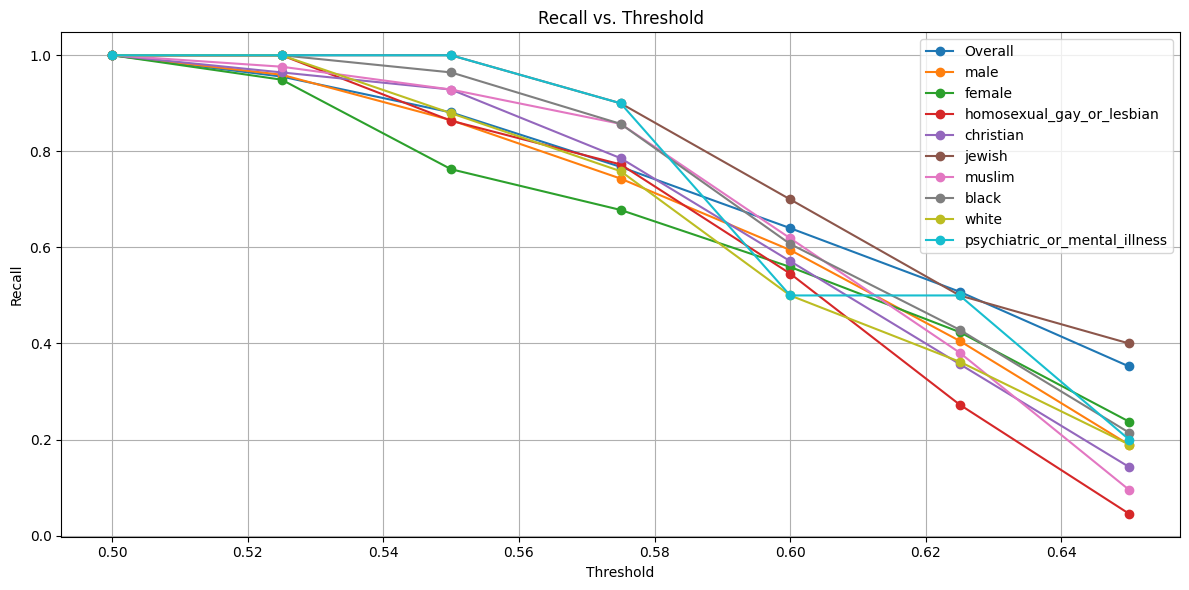

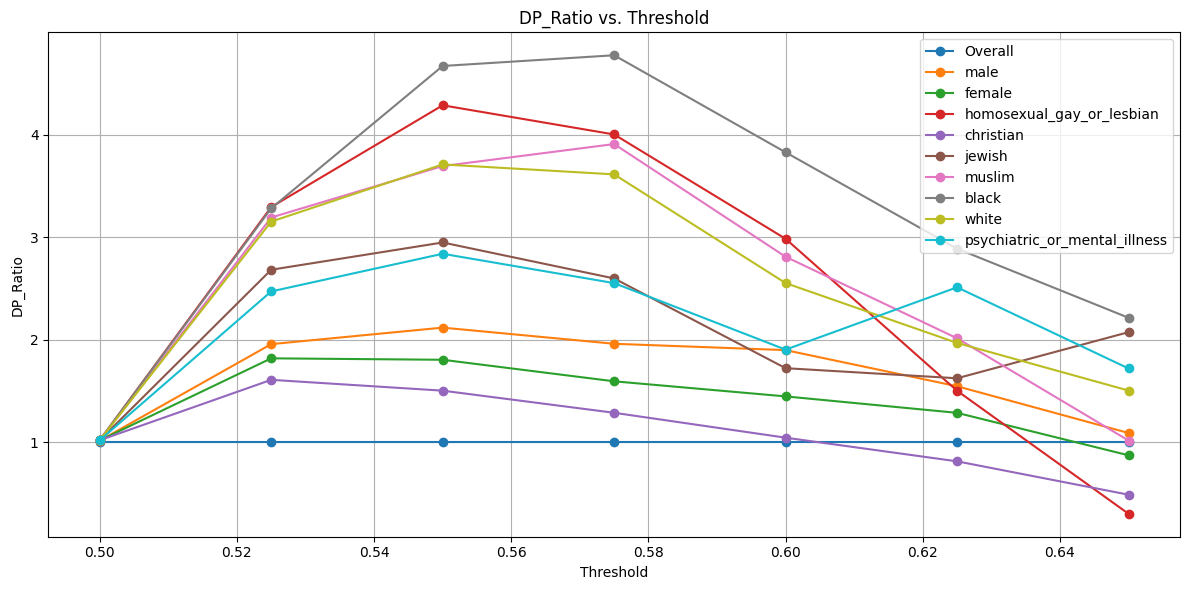

In [106]:
# Plot
metrics = ['Precision', 'Recall', 'DP_Ratio']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    for feature in ['Overall'] + class_features:
        values = [results[thr][feature][metric] for thr in thresholds]
        plt.plot(thresholds, values, marker='o', label=feature)
    plt.title(f'{metric} vs. Threshold')
    plt.xlabel('Threshold')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{metric.lower()}_threshold_plot.png')
    plt.show()